In [195]:
# This is a file about autoencoders
import torch
import torch.nn as nn
import torch.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [162]:
# Setting up for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Autoencoder 

In [163]:
# Dataset 
dataset = SVHN(root="./dataset", download=True, transform=transforms.ToTensor(), split="train")

# Train and evaluation split 
train_length = int(len(dataset) * 0.7)
val_length = int(len(dataset)) - train_length

# Randomly split the dataset into train, validation, and test sets
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_length, val_length])
test_dataset = SVHN(root="./dataset", download=True, transform=transforms.ToTensor(), split="test")

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Using downloaded and verified file: ./dataset/train_32x32.mat
Using downloaded and verified file: ./dataset/test_32x32.mat


In [164]:
# Custom Autoencoder class with one Layer
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3072),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [191]:
# Plot Loss Function
def plot_loss(epochs, losses):
    sns.set_style("dark")
    sns.set_theme(style="darkgrid")
    sns.scatterplot(x=epochs, y=losses, color="red")
    plt.grid(True)
    plt.title("Training Loss Graph")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

In [199]:
# Training Function
def train(total_epochs, model:nn.Module, train_loader:DataLoader, optimizer, criterion):
    model.train()
    losses = []
    epochs = [i for i in range(total_epochs)]
    for epoch in range(total_epochs):
        epoch_loss = 0
        for (image, _) in train_loader:
            features = image.reshape(-1, 32*32*3).float().to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, features)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss/len(train_loader))
        print(f"Epoch: {epoch+1} Loss: {epoch_loss/len(train_loader):.4f}")
    plot_loss(epochs, losses)

# Evaluation Function
def evaluate(model, test_loader, criterion): 
    with torch.no_grad:
        model.eval()
        total_loss = 0
        for image, _ in test_loader:
            features = image.reshape(-1, 32*32*3).float().to(device)
            output = model(features)
            print(type(output), type(features), type(image), image.shape, features.shape, output.shape)
            loss = criterion(output, features)
            total_loss += loss.item()
        print(f"Loss: {total_loss/len(test_loader):.4f}")

In [200]:
total_epochs = 10
learning_rate = 0.001   
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)


Epoch: 1 Loss: 0.0239
Epoch: 2 Loss: 0.0116
Epoch: 3 Loss: 0.0101
Epoch: 4 Loss: 0.0095
Epoch: 5 Loss: 0.0090
Epoch: 6 Loss: 0.0086
Epoch: 7 Loss: 0.0079
Epoch: 8 Loss: 0.0077
Epoch: 9 Loss: 0.0076
Epoch: 10 Loss: 0.0075


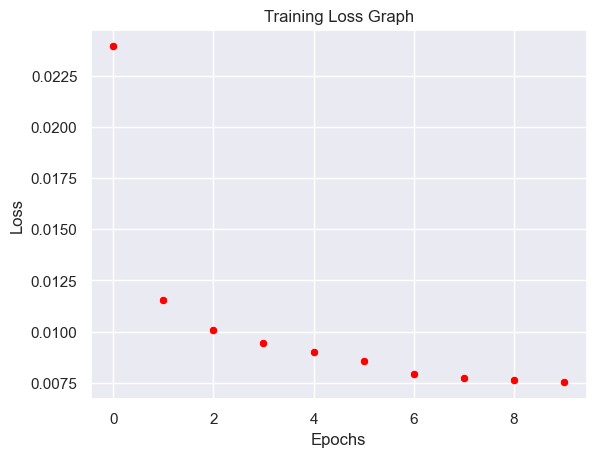

In [201]:
# Training Model
train(total_epochs, model, train_loader, optimizer, criterion)
torch.save(model.state_dict(), "autoencoder.pth")

In [ ]:
model = AutoEncoder()
model.load_state_dict(torch.load("autoencoder.pth"))
model.eval()
evaluate(model, test_loader, criterion)

torch.Size([128, 3072])


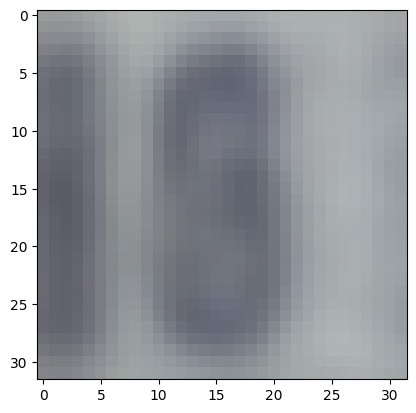

In [190]:
# Testing the Model
sample_data = None
for image, _ in test_loader:
    features = image.reshape(-1, 32*32*3).float().to(device)
    output = model(features)
    print(features.shape)
    sample_data = output
    break

sample_data = sample_data.reshape(-1, 3, 32, 32).cpu().detach().numpy()
sample_data = sample_data.transpose(0, 2, 3, 1)
plt.imshow(sample_data[0])
plt.show()

## Using Model as a Denoising Autoencoder

In [186]:
# Noising Function
def noise(image, noise_factor=0.5):
    noisy_image = image * (1 - noise_factor) + noise_factor * torch.randn(*image.shape)
    return noisy_image

# Plotting Noised Images
noisy_images

tensor([[[ 0.5898, -1.4498, -0.3195,  ..., -2.5108,  2.0120,  2.4541],
         [-0.5010, -0.6520, -0.7395,  ..., -0.3673,  0.0469, -0.1793],
         [-1.1044, -0.5866, -0.1401,  ..., -1.4378,  0.3307, -0.9413],
         ...,
         [ 0.0805, -0.2474,  1.0379,  ...,  1.2095, -1.4368,  0.4627],
         [ 0.9345, -0.3180, -0.9934,  ...,  1.9650, -0.7955,  1.4081],
         [-0.6691, -1.1095,  0.0541,  ...,  0.5500, -1.1360, -0.4657]],

        [[-1.3270, -2.3405,  0.4469,  ..., -1.6662, -1.3765, -0.5025],
         [ 1.0127,  2.2162,  0.3964,  ...,  0.9049, -1.5107,  0.0517],
         [-0.0834, -0.2978,  1.0214,  ..., -1.6014, -0.8275, -0.3306],
         ...,
         [ 1.3294,  1.4431,  1.9320,  ...,  0.6185, -0.3183, -1.1476],
         [ 0.8259, -0.9509,  0.1323,  ...,  0.9415,  0.1238,  1.2359],
         [-1.7292,  0.6807,  0.0734,  ...,  1.0130, -0.7770,  0.5026]],

        [[ 1.9868, -0.8406,  0.9884,  ...,  0.2923, -0.1544, -0.2333],
         [ 0.5716, -1.9854, -0.0538,  ..., -0